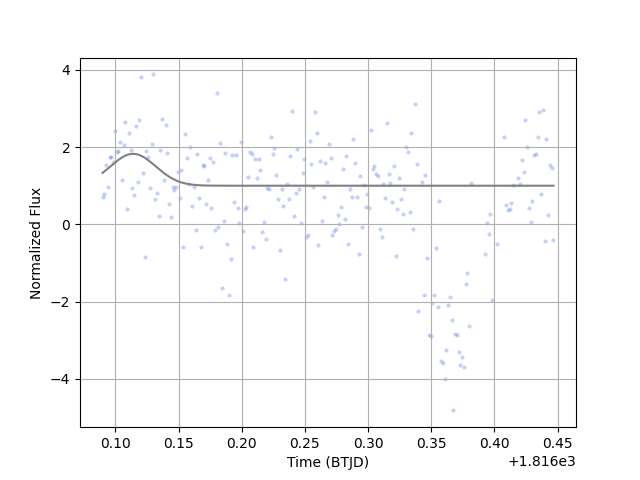


Parameters and their errors 1 :
A = -0.824989851600483 +/- 0.41274294461836153
mu = 1816.1139951752778 +/- 0.01119498972056587
Sigma = 0.017945253218109344 +/- 0.012468785618123037 



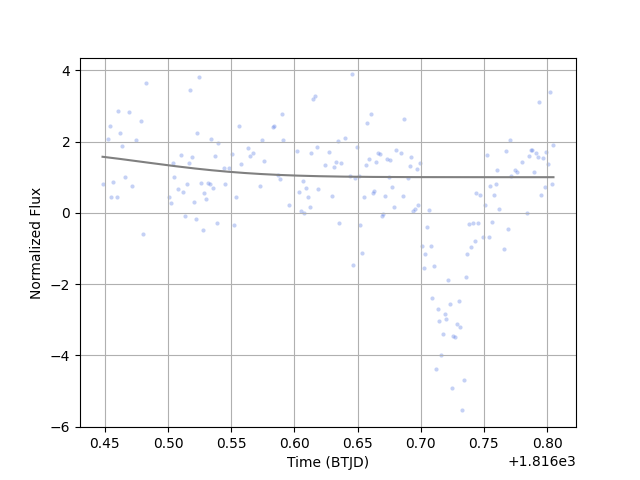


Parameters and their errors 2 :
A = -0.7100838764013121 +/- 4.639857746513772
mu = 1816.3889013060304 +/- 1.0306836251289062
Sigma = -0.09065844263867572 +/- 0.41219011566061475 



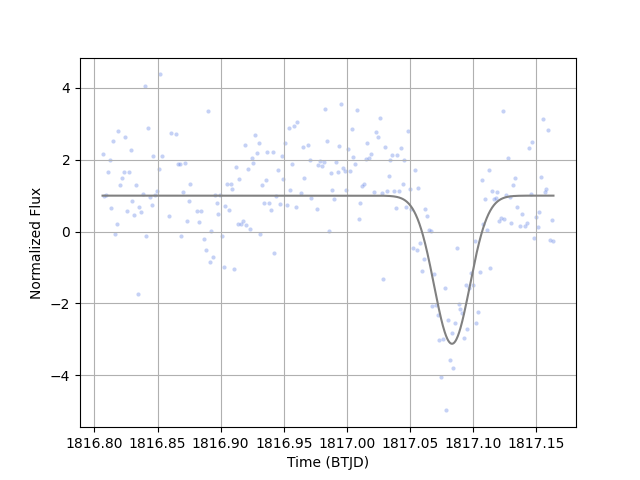


Parameters and their errors 3 :
A = 4.1258790224727955 +/- 0.3133027088717784
mu = 1817.0831150263682 +/- 0.0012410315126487731
Sigma = 0.014156268736351738 +/- 0.001241044242888473 



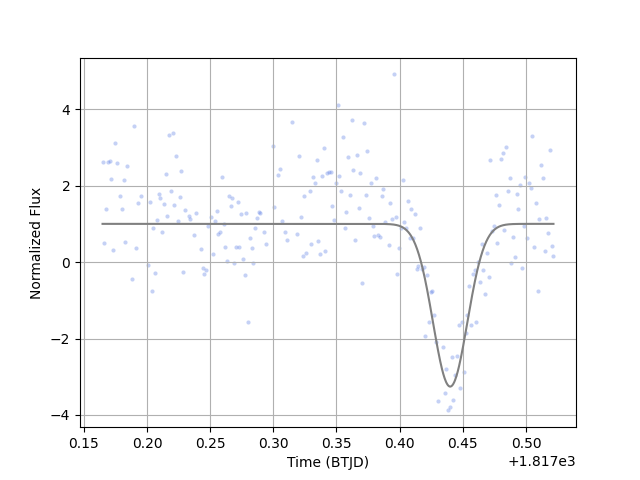


Parameters and their errors 4 :
A = 4.257210208053331 +/- 0.32860770682115503
mu = 1817.440023032392 +/- 0.0011953120358345558
Sigma = -0.01356070987256293 +/- 0.0011622079867804694 



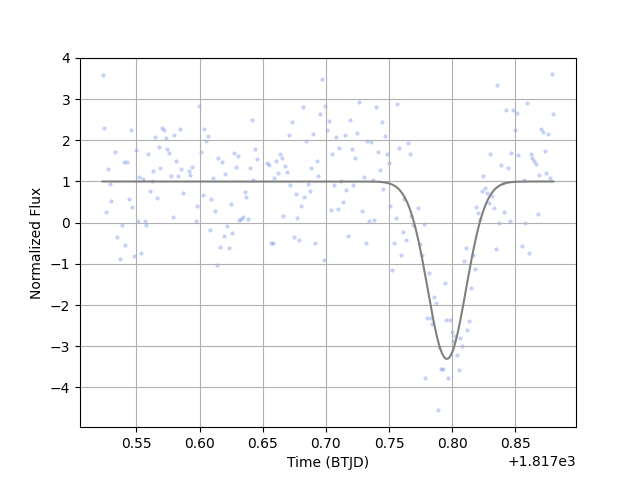


Parameters and their errors 5 :
A = 4.307388860283647 +/- 0.2833744297955753
mu = 1817.7957560678344 +/- 0.0011752399051865204
Sigma = -0.015191944424161693 +/- 0.0011929889270565445 



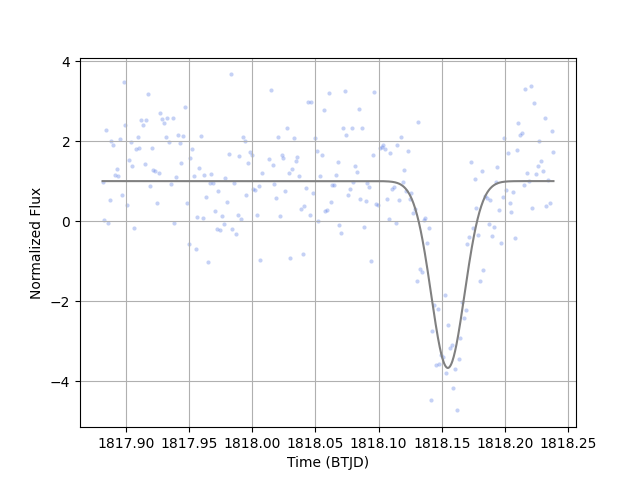


Parameters and their errors 6 :
A = 4.667776500689888 +/- 0.3063295310418879
mu = 1818.1548590031032 +/- 0.0009997015053562792
Sigma = 0.013189251880578843 +/- 0.0009997009782881392 



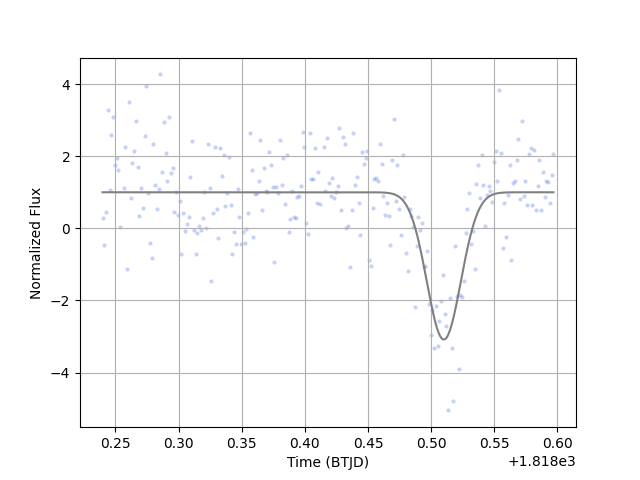


Parameters and their errors 7 :
A = 4.081935075737438 +/- 0.314834323317092
mu = 1818.5100271980837 +/- 0.0011988060063812397
Sigma = 0.013457731697507655 +/- 0.0011988053888287633 



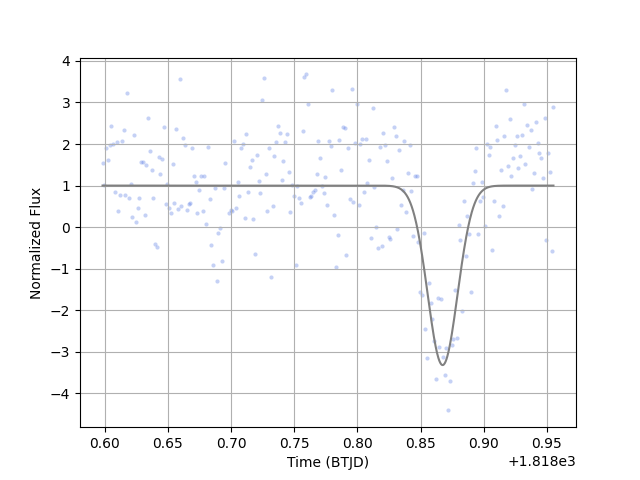


Parameters and their errors 8 :
A = 4.319478730886424 +/- 0.3267701049775368
mu = 1818.8674178210026 +/- 0.0010318984258497832
Sigma = -0.011810342748305764 +/- 0.0010318977468192114 



KeyboardInterrupt: 

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from astropy.time import Time
import lightkurve as lk
from scipy.optimize import curve_fit
import pandas as pd

TIC = 'TIC 3034524'

data_all = lk.search_lightcurve(TIC, author='SPOC')

data = data_all[0]

lc = data.download_all().stitch()

# Define the Gaussian function
def gaussian_function(x, A, mu, sigma):
    return -(A * np.exp(-((x - mu)**2) / (2 * sigma**2))-1)

def process_chunk(start_index, end_index, mu_fit):
    Times = lc.time[start_index:end_index]
    t = Time(Times)
    x = np.array(t.btjd)
    y = np.array(lc.flux[start_index:end_index])
    
    # Remove invalid values (infs and NaNs) from y and x arrays
    mask_valid = ~np.isnan(y) & ~np.isinf(y)
    x = x[mask_valid]
    y = y[mask_valid]
    
    while len(x) > 3:
        # Fitting the curve to the data
        initial_guess = [10, mu_fit, 0.17]  # Assume initial values for A, μ and σ
        params, covariance = curve_fit(gaussian_function, x, y, p0=initial_guess)
        # Get fitted values for A, μ and σ
        A_fit, mu_fit, sigma_fit = params

        # Get the diagonals of the covariance matrix as the variances of A, μ and σ
        var_A_fit, var_mu_fit, var_sigma_fit = np.diag(covariance)

        # Create points for the fitted curve
        x_fit = np.linspace(min(x), max(x), 1000)
        y_fit = gaussian_function(x_fit, A_fit, mu_fit, sigma_fit)

        # Calculate the errors as the square root of the variances
        error_A_fit = np.sqrt(var_A_fit)
        error_mu_fit = np.sqrt(var_mu_fit)
        error_sigma_fit = np.sqrt(var_sigma_fit)
        
        # Append the mu_fit and error_mu_fit to the lists
        mu_fit_values.append(mu_fit)
        error_mu_fit_values.append(error_mu_fit)
        plt.figure()
        plt.scatter(x, y, linewidth=0, color='royalblue', marker='.', alpha = 0.3)
        plt.plot(x_fit, y_fit, color='gray')
        plt.xlabel('Time (BTJD)')
        plt.ylabel('Normalized Flux')
        plt.grid(True)
        plt.show()

        print("\nParameters and their errors", i, ":")
        print("A =", A_fit, "+/-", error_A_fit)
        print("mu =", mu_fit, "+/-", error_mu_fit)
        print("Sigma =", sigma_fit, "+/-", error_sigma_fit, "\n")
        return mu_fit
    if len(x) <= 3:
        mu_guess=1829
        initial_guess = [A_guess, mu_guess, sigma_guess]
        mu_fit = initial_guess[1]

        return mu_fit
    
# Define initial guesses for A, mu, and sigma
A_guess = 10
mu_guess = 1816
sigma_guess = 0.17

# Create the initial_guess list
initial_guess = [A_guess, mu_guess, sigma_guess]

# Get the period in julian days
period_julian_days = 0.35745243660218606

# Initialize mu_fit with the initial guess value for mu
mu_fit = initial_guess[1]

mu_fit_values = []
error_mu_fit_values = []

# Iterate through the light curve and process chunks of data with the given period
start_index = 0
i=1
while start_index < len(lc):
    end_time = lc.time[start_index] + period_julian_days
    end_index = np.searchsorted(lc.time, end_time, side='right')
    
    # Call process_chunk with the updated mu_fit value
    mu_fit = process_chunk(start_index, end_index, mu_fit)
    mu_fit = mu_fit + period_julian_days
    
    #Update the start_index for the next iteration
    start_index = end_index
    i=i+1
    
# Create a table with mu_fit and error_mu_fit values
data_table = pd.DataFrame({
    'Mu fit': mu_fit_values,
    'Error mu fit': error_mu_fit_values
})

print(data_table)

#data_table.to_csv("/Users/valegarcia/Downloads/data_table.csv", index=False)
